In [1]:
# setup notebook if it is run on Google Colab, cwd = notebook file location
try:
    # change notebook_path if this notebook is in a different subfolder of Google Drive
    notebook_path = "Projects/QuantumFlow/notebooks"

    import os
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/" + notebook_path)

    %tensorflow_version 2.x
    !pip install -q ruamel.yaml

    %load_ext tensorboard
except:
    pass

# imports
import tensorflow as tf

# setup paths and variables for shared code (../quantumflow) and data (../data)
import sys
sys.path.append('../')
data_dir = "../data"

# import shared code, must run 0_create_shared_project_files.ipynb first!
from quantumflow.utils import load_hyperparameters, train, build_model, QFDataset

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
TensorFlow 2.x selected.


# Definitions

In [0]:
experiment = 'kd_resnet'

base_dir = os.path.join(data_dir, experiment)
if not os.path.exists(base_dir): os.makedirs(base_dir)

file_hyperparams = os.path.join(base_dir, "hyperparams.config")
file_model = os.path.join(base_dir, "model.py")

In [20]:
%%writefile $file_model
import tensorflow as tf
from quantumflow.keras_utils import CustomTensorBoard, WarmupExponentialDecay

class IntegrateLayer(tf.keras.layers.Layer):
    def __init__(self, h=1.0, **kwargs):
        super().__init__(**kwargs)
        self.h = h

    def call(self, inputs):
        return self.h*tf.reduce_sum((inputs[:, :-1] + inputs[:, 1:])/2., axis=1, name='trapezoidal_integral_approx')

    def get_config(self):
        config = super().get_config()
        config.update({'h': self.h})
        return config

class SymmetricConv1D(tf.keras.layers.Conv1D):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)
        self.kernel.assign(tf.concat([self.kernel[:(self.kernel_size[0]+1)//2], tf.reverse(self.kernel[:self.kernel_size[0]//2], axis=[0])], axis=0))

    def call(self, inputs):
        input_rev = tf.reverse(inputs, axis=[1])
        output = super().call(inputs)
        output_rev = super().call(input_rev)
        return 0.5*(output + tf.reverse(output_rev, axis=[1]))

def CNN_KineticEnergyFunctional(params):
    kernel_regularizer = tf.keras.regularizers.l2(params['model_kwargs']['l2_regularisation']) if params['model_kwargs'].get('l2_regularisation', 0.0) > 0.0 else None
    bias_initializer = tf.constant_initializer(value=params['dataset']['targets_mean']['kinetic_energy']) if params['model_kwargs'].get('bias_mean_initialisation', False) else None
    conv1d_layer = SymmetricConv1D if params['model_kwargs'].get('symmetric', False) else tf.keras.layers.Conv1D

    density = tf.keras.layers.Input(shape=params['dataset']['features_shape']['density'], name='density')
    value = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(density)
    
    for layer in range(len(params['model_kwargs']['filters'])):
        value = conv1d_layer(filters=params['model_kwargs']['filters'][layer], 
                             kernel_size=params['model_kwargs']['kernel_size'][layer], 
                             activation=params['model_kwargs']['activation'] if not params['model_kwargs'].get('batch_normalization', False) else None, 
                             padding=params['model_kwargs']['padding'],
                             kernel_regularizer=kernel_regularizer)(value)
        if params['model_kwargs'].get('batch_normalization', False):
            value = tf.keras.layers.BatchNormalization()(value)
            value = tf.keras.layers.Activation(params['model_kwargs']['activation'])(value)

    value = tf.keras.layers.Flatten()(value)
    value = tf.keras.layers.Dense(1, kernel_regularizer=kernel_regularizer, bias_initializer=bias_initializer)(value)
    kinetic_energy = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=-1), name='kinetic_energy')(value)

    return tf.keras.Model(inputs={'density': density}, outputs={'kinetic_energy': kinetic_energy})


def CNN_KineticEnergyDensityFunctional(params):
    kernel_regularizer = tf.keras.regularizers.l2(params['model_kwargs']['l2_regularisation']) if params['model_kwargs'].get('l2_regularisation', 0.0) > 0.0 else None
    bias_initializer = tf.constant_initializer(value=params['dataset']['targets_mean']['kinetic_energy']) if params['model_kwargs'].get('bias_mean_initialisation', False) else None

    density = tf.keras.layers.Input(shape=params['dataset']['features_shape']['density'], name='density')
    value = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(density)
    
    for layer in range(len(params['model_kwargs']['filters'])):
        value = tf.keras.layers.Conv1D(filters=params['model_kwargs']['filters'][layer], 
                                       kernel_size=params['model_kwargs']['kernel_size'][layer], 
                                       activation=params['model_kwargs']['activation'] if not params['model_kwargs'].get('batch_normalization', False) and layer < len(params['model_kwargs']['filters'])-1 else None, 
                                       padding=params['model_kwargs']['padding'],
                                       kernel_regularizer=kernel_regularizer)(value)

        if params['model_kwargs'].get('batch_normalization', False):
            value = tf.keras.layers.BatchNormalization()(value)

            if layer < len(params['model_kwargs']['filters'])-1:
                value = tf.keras.layers.Activation(params['model_kwargs']['activation'])(value)

    kinetic_energy_density = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=-1), name='kinetic_energy_density')(value)
    kinetic_energy = IntegrateLayer(params['dataset']['h'], name='kinetic_energy')(kinetic_energy_density)
    
    return tf.keras.Model(inputs={'density': density}, outputs={'kinetic_energy': kinetic_energy, 'kinetic_energy_density': kinetic_energy_density})


def ResNet_KineticEnergyDensityFunctional(params):
    kernel_regularizer = tf.keras.regularizers.l2(params['model_kwargs']['l2_regularisation']) if params['model_kwargs'].get('l2_regularisation', 0.0) > 0.0 else None
    bias_initializer = tf.constant_initializer(value=params['dataset']['targets_mean']['kinetic_energy']) if params['model_kwargs'].get('bias_mean_initialisation', False) else None

    density = tf.keras.layers.Input(shape=params['dataset']['features_shape']['density'], name='density')
    value = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(density)
    
    def resnet_block(input, filters, kernel_size, padding=None, activation=None, add_input=True):
        value = input
        for layer in range(len(filters)):
            value = tf.keras.layers.Conv1D(filters=filters[layer], 
                                        kernel_size=kernel_size[layer], 
                                        padding=padding,
                                        use_bias=True,
                                        activation= activation if layer < len(filters)-1 else None,
                                        kernel_regularizer=kernel_regularizer)(value)

        if add_input:
            value = tf.keras.layers.Add()([value, input])
        
        if activation is not None:
            return tf.keras.layers.Activation(activation=activation)(value)
        else:
            return value

    for layer in range(len(params['model_kwargs']['blocks'])):
        value = resnet_block(value, **params['model_kwargs']['blocks'][layer])

    kinetic_energy_density = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=-1), name='kinetic_energy_density')(value)
    kinetic_energy = IntegrateLayer(params['dataset']['h'], name='kinetic_energy')(kinetic_energy_density)
    
    return tf.keras.Model(inputs={'density': density}, outputs={'kinetic_energy': kinetic_energy, 'kinetic_energy_density': kinetic_energy_density})


class KineticEnergyFunctionalDerivativeModel(tf.keras.Model):
    def __init__(self, params):
        super().__init__()
        self.model = params['model_kwargs']['base_model'](params)
        self.h = tf.constant(params['dataset']['h'], dtype=params['dtype'])

        self.output_names = sorted(['derivative'] + self.model.output_names)
        self.input_names = self.model.input_names

    @tf.function
    def call(self, density):
        density = tf.nest.flatten(density)

        with tf.GradientTape() as tape:
            tape.watch(density)
            predictions = self.model(density)
            kinetic_energy = predictions['kinetic_energy']

        predictions['derivative'] = tf.identity(1/self.h*tape.gradient(kinetic_energy, density), name='derivative')
        return predictions

    def fit(self, y=None, validation_data=None, **kwargs):
        if isinstance(y, dict):
            y = tf.nest.flatten(y)
        
        if isinstance(validation_data, (tuple, list)) and isinstance(validation_data[1], dict):
            validation_data = (validation_data[0], tf.nest.flatten(validation_data[1]))

        super().fit(y=y, validation_data=validation_data, **kwargs)

    def _set_output_attrs(self, outputs):
        super()._set_output_attrs(outputs)
        self.output_names = sorted(['derivative'] + self.model.output_names)

    def summary(self, *args, **kwargs):
        return self.model.summary(*args, **kwargs)

    def save(self, *args, **kwargs):
        return self.model.save(*args, **kwargs)

    def save_weights(self, *args, **kwargs):
        self.model.optimizer = self.optimizer
        returns = self.model.save_weights(*args, **kwargs)
        self.model.optimizer = None
        return returns

    def load_weights(self, *args, **kwargs):
        self.model.optimizer = self.optimizer
        returns = self.model.load_weights(*args, **kwargs)
        self.optimizer = self.model.optimizer
        self.model.optimizer = None
        return returns


#from tensorflow_addons.optimizers import RectifiedAdam, Lookahead

#def Ranger(*args, **kwargs):
#    return Lookahead(RectifiedAdam(*args, **kwargs))

Writing ../data/kd_resnet/model.py


In [0]:
%run $file_model

In [32]:
%%writefile $file_hyperparams
globals: 
    - CNN_KineticEnergyFunctional
    - CNN_KineticEnergyDensityFunctional
    - KineticEnergyFunctionalDerivativeModel
    - ResNet_KineticEnergyDensityFunctional
    - WarmupExponentialDecay
    - CustomTensorBoard
    #- RectifiedAdam
    #- Ranger

default: &DEFAULT
    load_checkpoint: null

    N: 1
    seed: 0
    dtype: float32
    dataset_train: recreate/dataset_paper.hdf5
    dataset_validate: recreate/dataset_validate.hdf5
    dataset_info:
        shapes: True
        h: True

    model: CNN_KineticEnergyFunctional
    model_kwargs: &DEFAULT_MODEL_KWARGS
        filters: [32, 32, 32, 32, 32]
        kernel_size: [100, 100, 100, 100, 100]
        padding: valid
        activation: softplus
        l2_regularisation: 0.00025
        bias_mean_initialisation: False
        batch_normalization: False

    features: [density]
    targets: [kinetic_energy]

    metrics: [mean_absolute_error]
    loss: [mean_squared_error]

    optimizer: Adam
    optimizer_kwargs: &DEFAULT_OPTIMIZER_KWARGS
        learning_rate: WarmupExponentialDecay
        beta_1: 0.9
        beta_2: 0.999
        epsilon: 1e-07
        amsgrad: False

        clipnorm: 100.0

        learning_rate_kwargs:
            initial_learning_rate: 0.001
            final_learning_rate: 0.0000001
            decay_rate: 0.99 
            decay_steps: 100 # batches

            cold_steps: 1000 # batches
            warmup_steps: 1000 # batches
            cold_factor: 0.1

    fit_kwargs:
        batch_size: 100
        epochs: 100000
        verbose: 0
        #validation_split: 0.1
        validation_freq: 10000 # epochs
        shuffle: False
        initial_epoch: 0

    checkpoint: True
    checkpoint_kwargs:
        filename: weights.{epoch:03d}.tf
        save_freq: 2000000 # samples
        save_weights_only: True

    tensorboard: CustomTensorBoard
    tensorboard_kwargs:
        histogram_freq: 10000 # epochs
        metrics_freq: 100 # epochs
        write_graph: True
        write_images: True
        update_freq: epoch
        profile_batch: 0

    save_model: True
    export: True
    export_model: self # part of the model to export 

cnn: &CNN
    <<: *DEFAULT
    model: KineticEnergyFunctionalDerivativeModel
    model_kwargs: &CNN_MODEL_KWARGS
        base_model: CNN_KineticEnergyFunctional
        filters: [32, 32, 32, 32, 32]
        kernel_size: [100, 100, 100, 100, 100]
        padding: valid
        activation: softplus
        l2_regularisation: 0.00025
        bias_mean_initialisation: False
        batch_normalization: False

    features: [density]
    targets: [kinetic_energy, derivative]

    metrics: 
        kinetic_energy: mean_absolute_error
        derivative: mean_absolute_error

    loss: 
        kinetic_energy: mean_squared_error
        derivative: mean_squared_error

    loss_weights:
        kinetic_energy: 0.2
        derivative: 1.0

    save_model: False
    export_model: model

    # hyperparameter
    int_min: 
        seed: 0
    int_max:
        seed: 9

density: &DENSITY
    <<: *DEFAULT
    model: KineticEnergyFunctionalDerivativeModel
    model_kwargs: &DENSITY_MODEL_KWARGS
        base_model: CNN_KineticEnergyDensityFunctional
        filters: [32, 32, 32, 32, 32]
        kernel_size: [100, 100, 100, 100, 100]
        padding: same
        activation: softplus
        l2_regularisation: 0.00025
        bias_mean_initialisation: False
        batch_normalization: True

    features: [density]
    targets: [kinetic_energy, kinetic_energy_density, derivative]

    metrics: 
        kinetic_energy: mean_absolute_error
        kinetic_energy_density: mean_absolute_error
        derivative: mean_absolute_error

    loss: 
        kinetic_energy: mean_squared_error
        kinetic_energy_density: mean_squared_error
        derivative: mean_squared_error

    loss_weights:
        kinetic_energy: 0.0
        kinetic_energy_density: 1.0
        derivative: 1.0

    optimizer: Adam
    optimizer_kwargs:
        learning_rate: WarmupExponentialDecay
        beta_1: 0.99
        beta_2: 0.999
        epsilon: 1e-03
        amsgrad: True

        clipnorm: 100.0

        learning_rate_kwargs:
            initial_learning_rate: 0.001
            final_learning_rate: 0.0000001
            decay_rate: 0.99 
            decay_steps: 100 # batches

            cold_steps: 1000 # batches
            warmup_steps: 1000 # batches
            cold_factor: 0.1

    save_model: False
    export_model: model


resnet: &RESNET
    load_checkpoint: null

    N: 1
    seed: 0
    dtype: float32
    dataset_train: recreate/dataset_paper.hdf5
    dataset_validate: recreate/dataset_validate.hdf5
    dataset_info:
        shapes: True
        h: True

    model: KineticEnergyFunctionalDerivativeModel
    model_kwargs: &RESNET_MODEL_KWARGS
        base_model: ResNet_KineticEnergyDensityFunctional
        l2_regularisation: 0.00025
        bias_mean_initialisation: False
        batch_normalization: False

        resnet_block_kwargs: &RESNET_RESNET_BLOCK
            filters: [32, 32]
            kernel_size: [100, 100]
            padding: same
            activation: softplus
            add_input: True

        final_block_kwargs: &RESNET_FINAL_BLOCK
            filters: [1]
            kernel_size: [100]
            padding: same
            activation: null
            add_input: False

        blocks: [<<: *RESNET_RESNET_BLOCK,
                 <<: *RESNET_RESNET_BLOCK,
                 <<: *RESNET_RESNET_BLOCK,
                 <<: *RESNET_FINAL_BLOCK]
                    

    features: [density]
    targets: [kinetic_energy, kinetic_energy_density, derivative]

    metrics: 
        kinetic_energy: mean_absolute_error
        kinetic_energy_density: mean_absolute_error
        derivative: mean_absolute_error

    loss: 
        kinetic_energy: mean_squared_error
        kinetic_energy_density: mean_squared_error
        derivative: mean_squared_error

    loss_weights:
        kinetic_energy: 0
        kinetic_energy_density: 1.0
        derivative: 1.0

    optimizer: Adam
    optimizer_kwargs:
        learning_rate: WarmupExponentialDecay
        beta_1: 0.9
        beta_2: 0.999
        epsilon: 1e-07
        amsgrad: False

        clipnorm: 100.0

        learning_rate_kwargs:
            initial_learning_rate: 0.001
            final_learning_rate: 0.0000001
            decay_rate: 0.9
            decay_steps: 1000 # batches

            cold_steps: 1000 # batches
            warmup_steps: 1000 # batches
            cold_factor: 0.1

    fit_kwargs:
        batch_size: 100
        epochs: 100000
        verbose: 0
        #validation_split: 0.1
        validation_freq: 10000 # epochs
        shuffle: False
        initial_epoch: 0

    checkpoint: True
    checkpoint_kwargs:
        filename: weights.{epoch:03d}.tf
        save_freq: 2000000 # samples
        save_weights_only: True

    tensorboard: CustomTensorBoard
    tensorboard_kwargs:
        histogram_freq: 10000 # epochs
        metrics_freq: 100 # epochs
        write_graph: True
        write_images: True
        update_freq: epoch
        profile_batch: 0

    save_model: False
    export: True
    export_model: model

    # hyperparameter
    #int_min: 
    #    seed: 0
    #int_max:
    #    seed: 9

resnet_l2:
    <<: *RESNET
    model_kwargs:
        <<: *RESNET_MODEL_KWARGS
        l2_regularisation: 0.001

resnet_l2_more:
    <<: *RESNET
    model_kwargs:
        <<: *RESNET_MODEL_KWARGS
        l2_regularisation: 0.0025

resnet_l2_less:
    <<: *RESNET
    model_kwargs:
        <<: *RESNET_MODEL_KWARGS
        l2_regularisation: 0.000025


resnet_l2_normal:
    <<: *RESNET
    model_kwargs:
        <<: *RESNET_MODEL_KWARGS
        l2_regularisation: 0.00025

resnet_long:
    <<: *RESNET
    #load_checkpoint: 'kd_cnn/resnet_long/weights.180000.tf'

    fit_kwargs:
        batch_size: 100
        epochs: 200000
        verbose: 0
        #validation_split: 0.1
        validation_freq: 10000 # epochs
        shuffle: False
        initial_epoch: 0


resnet_finish:
    load_checkpoint: 'kd_cnn/resnet_long/weights.60000.tf'
    <<: *RESNET
    fit_kwargs:
        batch_size: 100
        epochs: 200000
        verbose: 0
        #validation_split: 0.1
        validation_freq: 10000 # epochs
        shuffle: False
        initial_epoch: 60000

    optimizer: Adam
    optimizer_kwargs:
        learning_rate: WarmupExponentialDecay
        beta_1: 0.9
        beta_2: 0.999
        epsilon: 1e-07
        amsgrad: False

        clipnorm: 100.0

        learning_rate_kwargs:
            initial_learning_rate: 0.001
            final_learning_rate: 0.000001
            decay_rate: 0.9
            decay_steps: 1000 # batches

            cold_steps: 1000 # batches
            warmup_steps: 1000 # batches
            cold_factor: 0.1


# Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285: 6790 examples/sec
# name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7

Overwriting ../data/kd_resnet/hyperparams.config


# Tensorboard

In [30]:
%tensorboard --logdir=$base_dir

Output hidden; open in https://colab.research.google.com to view.

In [0]:
!rm -r $base_dir/resnet

# Start Trainings

In [33]:
%%python --bg --out out --err err
import sys; sys.path.append('../')
from quantumflow.utils import run_experiment
run_experiment(experiment='kd_resnet', run_name='resnet_l2_normal')

Starting job # 4 in a separate thread.


In [0]:
#%%python --bg --out out --err err
import sys; sys.path.append('../')
from quantumflow.utils import run_multiple
run_multiple(experiment='kd_cnn', run_name='resnet')

In [26]:
import threading
background_jobs = [thread for thread in threading.enumerate() if thread.__class__.__name__ == 'BackgroundJobFunc']
display(background_jobs)
if len(background_jobs) == 0 and 'out' in globals():
    print(out.read().decode('utf-8'))
    print(err.read().decode('utf-8'))

[<BackgroundJob #0: <bound method ScriptMagics._run_script of <IPython.core.magics.script.ScriptMagics object at 0x7fb137d22be0>>>]

# Test

In [0]:
from collections import OrderedDict

class SampleCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, sample_freq=1, merge_layers=None):
        super().__init__()
        self.dataset = dataset
        self.predictions = []
        self.weights = []
        self.layers = []
        self.epochs = []
        self.metrics = []
        self.additional = []
        
        self.merge_layers = merge_layers or {}

        self.sample_freq = sample_freq

    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.sample_freq == 0:
            self.epochs.append(epoch)
            self.predictions.append(self.model(self.dataset.features))
            self.weights.append({weight.name: weight.numpy() for weight in self.model.trainable_variables})
    
            layers_dict = OrderedDict()

            def add_layer(layer, value, name):
                if layer.name in self.merge_layers:
                    value = layer([value, layers_dict[self.merge_layers[layer.name]]])
                else:
                    value = layer(value)
                layers_dict[name] = value.numpy()
                return value

            value = self.dataset.density #tf.nest.flatten(self.dataset.features)
            for layer in self.model.layers:
                if hasattr(layer, 'layers'): # sub-model
                    for sub_layer in layer.layers:
                        value = add_layer(sub_layer, value, layer.name + '/' + sub_layer.name)
                else:
                    value = add_layer(layer, value, layer.name)

            self.layers.append(layers_dict)


    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.sample_freq == 0:
            self.metrics.append(logs)
            self.additional.append({'learning_rate': self.model.optimizer._decayed_lr(tf.float32).numpy(),
                                    'adam_iterations': self.model.optimizer.iterations.numpy(),
                                    'adam_m_' + self.model.trainable_variables[0].name: self.model.optimizer.get_slot(self.model.trainable_variables[0], 'm').numpy(),
                                    'adam_v_' + self.model.trainable_variables[0].name: self.model.optimizer.get_slot(self.model.trainable_variables[0], 'v').numpy(),
                                    'adam_beta_1': self.model.optimizer._get_hyper('beta_1', tf.float32).numpy()})
    def get_metric(self, key):
        return tf.stack([metric[key] for metric in self.metrics])

    def get_prediction(self, key):
        return tf.stack([prediction[key] for prediction in self.predictions])

    def get_weight(self, key):
        return tf.stack([weight[key] for weight in self.weights])

    def get_layer(self, key):
        return tf.stack([layer[key] for layer in self.layers])
    
    def get_additional(self, key):
        return tf.stack([add[key] for add in self.additional])


In [0]:
from quantumflow.utils import anim_plot
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [0]:
run_name = 'full_symmetric'
load_checkpoint = 0
run_epochs = 100000
sample_freq = 500
model_dir = os.path.join(data_dir, experiment, run_name)

params = load_hyperparameters(file_hyperparams, run_name=run_name, globals=globals())
model = build_model(params)
display(model.summary())

params = load_hyperparameters(file_hyperparams, run_name=run_name, globals=globals())
params['fit_kwargs']['initial_epoch'] = load_checkpoint
params['load_checkpoint'] = ('kd_cnn/{}/' + params['checkpoint_kwargs']['filename']).format(run_name, epoch=load_checkpoint) if load_checkpoint else None
params['fit_kwargs']['epochs'] = params['fit_kwargs']['initial_epoch'] + run_epochs

merge_layers = {'add': 'model/lambda',
                'add_1': 'model/activation',
                'add_2': 'model/activation_1',
                'add_3': 'model/activation_2',
                'add_4': 'model/activation_3'}

#model_dir = '../data/pop_test/' + run_name

#params['dataset'] = {'h': 1/499}
#params['loss'] = {'kinetic_energy': params['loss']['kinetic_energy'], 'derivative': params['loss']['derivative'](params)}

sample_callback = SampleCallback(QFDataset(os.path.join(data_dir, 'recreate/dataset_sample.hdf5'), params), sample_freq=sample_freq, merge_layers=merge_layers)
model, params = train(params, callbacks=[sample_callback], model_dir=globals().get('model_dir', None))


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
density (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
lambda (Lambda)              (None, 500, 1)            0         
_________________________________________________________________
symmetric_conv1d (SymmetricC (None, 401, 32)           3232      
_________________________________________________________________
symmetric_conv1d_1 (Symmetri (None, 302, 32)           102432    
_________________________________________________________________
symmetric_conv1d_2 (Symmetri (None, 203, 32)           102432    
_________________________________________________________________
symmetric_conv1d_3 (Symmetri (None, 104, 32)           102432    
_________________________________________________________________
symmetric_conv1d_4 (Symmetri (None, 5, 32)             102432

None

In [0]:
print(sample_callback.weights[0].keys())
print(sample_callback.metrics[0].keys())

In [0]:
plt.figure(figsize=(20, 3))
plt.plot(sample_callback.epochs, sample_callback.get_prediction('kinetic_energy'))
plt.show()

In [0]:
kedensity = sample_callback.get_prediction('kinetic_energy_density')
kedensity = np.stack([kedensity, np.repeat(np.expand_dims(sample_callback.dataset.kinetic_energy_density, axis=0), len(kedensity), axis=0)], axis=2)
print(kedensity.shape)
anim_plot(np.moveaxis(kedensity[:, 0], 2, 1), bar='Rendering')

KeyError: ignored

In [0]:
derivative = sample_callback.get_prediction('derivative')
derivative = np.stack([derivative[:, 0], np.repeat(np.expand_dims(sample_callback.dataset.derivative, axis=0), len(derivative), axis=0)], axis=2)
print(derivative.shape)
anim_plot(np.moveaxis(derivative[:, 0], 2, 1), bar='Rendering')

(100, 1, 2, 500)


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'))

In [0]:
layer_names = sample_callback.layers[0].keys()

for layer_name in layer_names:
    print(layer_name)
    value = sample_callback.get_layer(layer_name)
    #frame = 0
    #plt.figure(figsize=(10, 1))
    #plt.plot(value[frame][0])
    #plt.title(layer_name + ' ' + str(value[frame].shape))
    #plt.show()

    if len(value.shape) < 3:
        continue
    if len(value.shape) == 3:
        value = tf.expand_dims(value, axis=-1)

    anim_plot(value[:, 0], figsize=(10, 1), bar='Rendering')

model/density


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'))

model/lambda


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'))

model/symmetric_conv1d


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'))

model/symmetric_conv1d_1


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'))

model/symmetric_conv1d_2


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'))

model/symmetric_conv1d_3


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'))

model/symmetric_conv1d_4


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'))

model/flatten


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'))

model/dense


IntProgress(value=0, bar_style='success', description='Rendering', layout=Layout(width='92%'))

../quantumflow/utils.py:95: UserWarning: Attempting to set identical bottom == top == 5.507802963256836 results in singular transformations; automatically expanding.
  ax.set_ylim([min_last - span_last*0.2, max_last + span_last*0.2])


model/kinetic_energy


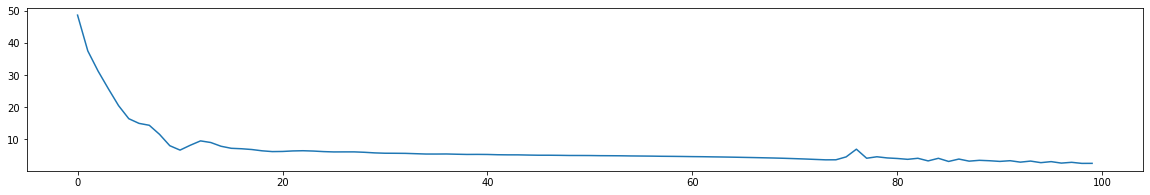

In [0]:
plt.figure(figsize=(20, 3))
plt.plot(sample_callback.epochs, sample_callback.get_metric('loss'))
plt.show()

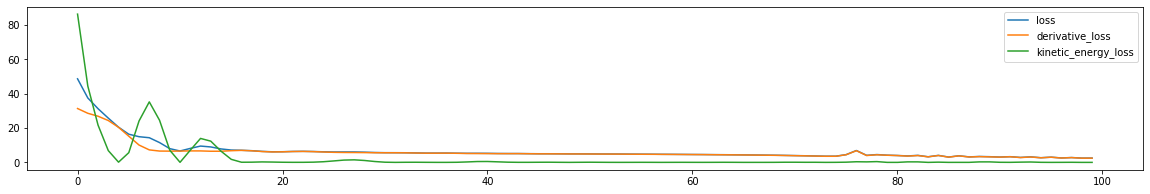

In [0]:
plt.figure(figsize=(20, 3))
for key in sample_callback.metrics[0].keys():
    if 'loss' not in key:
        continue
    metric = sample_callback.get_metric(key)
    while len(metric.shape) > 1:
        metric = tf.reduce_mean(metric, axis=-1)

    plt.plot(sample_callback.epochs, metric, label=key)

plt.legend()
plt.show()

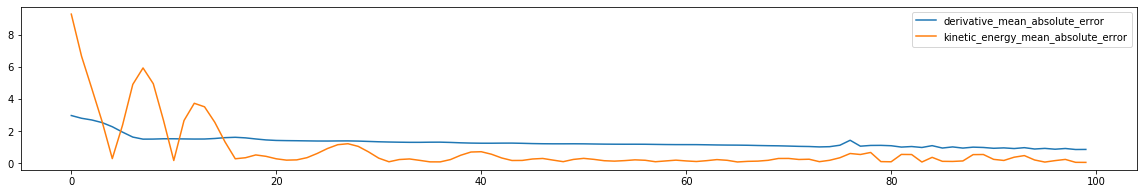

In [0]:
plt.figure(figsize=(20, 3))
for key in sample_callback.metrics[0].keys():
    if 'mean' not in key:
        continue
    metric = sample_callback.get_metric(key)
    while len(metric.shape) > 1:
        metric = tf.reduce_mean(metric, axis=-1)

    plt.plot(sample_callback.epochs, metric, label=key)

plt.legend()
plt.show()

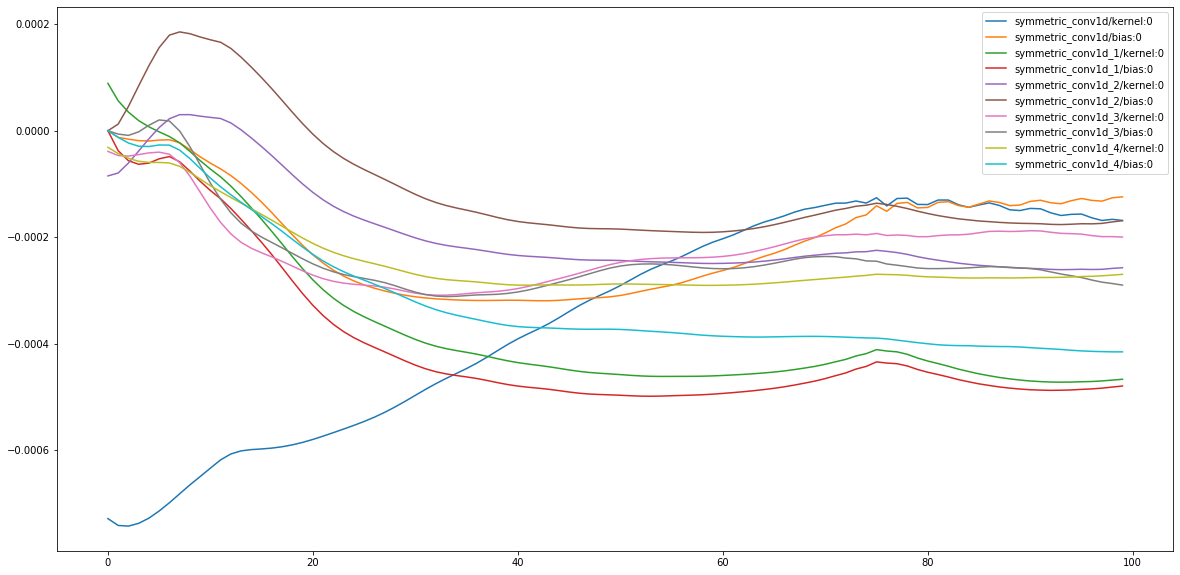

In [0]:
plt.figure(figsize=(20, 10))
for key in sample_callback.weights[0].keys():
    if not 'conv' in key:
        continue
    weight = sample_callback.get_weight(key)
    while len(weight.shape) > 1:
        weight = tf.reduce_mean(weight, axis=-1)

    plt.plot(sample_callback.epochs, weight, label=key)

plt.legend()
plt.show()

In [0]:
kernel = sample_callback.get_weight('symmetric_conv1d_3/kernel:0')
anim_plot(kernel[:, :, 0], bar='Rendering')
gradient = kernel[1:] - kernel[:-1]
anim_plot(gradient[:, 0], bar='Rendering')
plt.figure(figsize=(20, 3))
plt.plot(np.log(tf.reduce_sum(tf.square(tf.reshape(gradient, [run_epochs//sample_freq-1, -1])), axis=-1)))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#Analysis

In [0]:
import pandas as pd
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record

def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def load_summaries(event_dir, progress=None):
    
    values = {}

    if not os.path.exists(event_dir):
        return values

    values['wall_time'] = ([], [])

    event_files = [os.path.join(event_dir, file) for file in os.listdir(event_dir) if '.tfevents' in file]

    if progress is not None and isinstance(progress, int) and progress > 0:
        progress = widgets.IntProgress(value=0, max=progress, description='Reading...', bar_style='info', layout=widgets.Layout(width='92%'))
        display(progress)

    def create_or_append(step, tag, value):
        try:
            if step not in values[tag][0]:
                values[tag][0].append(step)
                values[tag][1].append(value)
        except KeyError:
            values[tag] = ([step], [value])
            
    for event_file in event_files:
        for summary in my_summary_iterator(event_file):
            if summary.summary.value.__len__() == 0: continue      

            if summary.step not in values['wall_time'][0]:
                values['wall_time'][0].append(summary.step)
                values['wall_time'][1].append(summary.wall_time)

                if progress is not None and summary.step - progress.value >= progress.max//100:
                    progress.value = summary.step

            for entry in summary.summary.value:
                if entry.tag == 'keras':
                    continue # model config
                elif 'bias' in entry.tag or 'kernel' in entry.tag: 
                    if 'image' in entry.tag:
                        create_or_append(summary.step, 'image/' + entry.tag.replace('image/', ''), entry.image.encoded_image_string)
                    else:
                        continue #histograms
                else: # metrics
                    create_or_append(summary.step, entry.tag, entry.simple_value)
                
    for key in values.keys():        
        values[key] = pd.DataFrame(values[key][1], index=values[key][0], columns=[key])
    return values


def load_summaries2(event_dir, progress=None):
    summaries = {}

    if not os.path.exists(event_dir):
        return summaries

    event_files = [os.path.join(event_dir, file) for file in os.listdir(event_dir) if '.tfevents' in file]

    if progress is not None and isinstance(progress, int) and progress > 0:
        progress = widgets.IntProgress(value=0, max=progress, description='Reading...', bar_style='info', layout=widgets.Layout(width='92%'))
        display(progress)

    def create_or_append(tag, step, wall_time, keys, values):
        try:
            if step not in summaries[tag]['step']:
                summaries[tag]['step'].append(step)
                #summaries[tag]['wall_time'].append(wall_time)
                if isinstance(keys, list):
                    for key, value in zip(keys, values):
                        summaries[tag][key].append(value)
                else:
                    summaries[tag][keys] = values
        except KeyError:
            summaries[tag] = {'step': [step]}#, 'wall_time': [wall_time]}
            if isinstance(keys, list):
                for key, value in zip(keys, values):
                    summaries[tag][key] = [value]
            else:
                summaries[tag][keys] = values
            
    for event_file in event_files:
        for summary in my_summary_iterator(event_file):
            if summary.summary.value.__len__() == 0: continue   

            if progress is not None and summary.step - progress.value >= progress.max//100:
                progress.value = summary.step

            for entry in summary.summary.value:
                if entry.tag == 'keras':
                    continue # model config
                elif 'bias' in entry.tag or 'kernel' in entry.tag: 
                    if 'image' in entry.tag:
                        create_or_append('image/' + entry.tag.replace('image/', ''), summary.step, summary.wall_time, entry.tag.replace('image/', ''), entry.image.encoded_image_string)
                    else:
                        continue #histograms
                else: # metrics
                    create_or_append(entry.tag, summary.step, summary.wall_time, 'simple_value', entry.simple_value)
                
    for key in summaries.keys():
        summaries[key] = pd.DataFrame(data=summaries[key]).set_index('step')
    return summaries

In [0]:
run_name = 'direct'

preview = 5
figsize = (20, 3)
dpi = None
kcalmol_per_hartree = 627.51

summary_train = load_summaries2(os.path.join(data_dir, experiment, run_name, 'train'), progress=100000)
summary_validation = load_summaries2(os.path.join(data_dir, experiment, run_name, 'validation'), progress=100000)

display(summary_train.keys())
display(summary_validation.keys())

In [0]:
from functools import reduce
images = reduce(lambda x, y: pd.merge(x, y, on = 'Date'), [value for key, value in summary_train.items() if 'image' in key])
images